# Task-7

## Important

In [1]:
#!pip install datasets
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
#import pandas and matplotlib for accurcy visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

## Load data

In [2]:
train_dir='xray_dataset_covid19/train'
val_dir = 'xray_dataset_covid19/valid'
test_dir='xray_dataset_covid19/test'

In [3]:
import os
classes_train=os.listdir(train_dir)
classes_val = os.listdir(val_dir)
classes_test=os.listdir(test_dir)

In [4]:
classes_train

['NORMAL', 'PNEUMONIA']

In [5]:
train_labels = ['NORMAL', 'PNEUMONIA']
class_train = {}
for label in train_labels:
    class_dir = os.path.join(train_dir, label)
    num_images = len(os.listdir(class_dir))    
    class_train[label] = num_images
for label, count in class_train.items():
    print(f"Class: {label}, Number of Images: {count}")

Class: NORMAL, Number of Images: 1104
Class: PNEUMONIA, Number of Images: 2973


In [6]:
classes_test

['NORMAL', 'PNEUMONIA']

In [7]:
test_labels = ['NORMAL', 'PNEUMONIA']
class_test = {}
for label2 in test_labels:
    class_dir2 = os.path.join(test_dir, label2)
    num_images2 = len(os.listdir(class_dir2))    
    class_test[label2] = num_images2
for label2, count2 in class_test.items():
    print(f"Class: {label2}, Number of Images: {count2}")

Class: NORMAL, Number of Images: 171
Class: PNEUMONIA, Number of Images: 411


In [8]:
classes_val

['NORMAL', 'PNEUMONIA']

In [9]:
val_labels = ['NORMAL', 'PNEUMONIA']
class_val = {}
for label3 in val_labels:
    class_dir3 = os.path.join(val_dir, label3)
    num_images3 = len(os.listdir(class_dir3))    
    class_val[label3] = num_images3
for label3, count3 in class_val.items():
    print(f"Class: {label3}, Number of Images: {count3}")

Class: NORMAL, Number of Images: 304
Class: PNEUMONIA, Number of Images: 861


## Preprocessing

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os

class_directories = {
    'NORMAL': 'xray_dataset_covid19/train/NORMAL',
    'PNEUMONIA': 'xray_dataset_covid19/train/PNEUMONIA'
}
target_count = 5000
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
for class_name, class_dir in class_directories.items():
    num_images = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
    if num_images >= target_count:
        print(f"Number of images in '{class_name}' class already exceeds the target count. Skipping augmentation.")
        continue

    print(f"Augmenting images for '{class_name}' class...")
    augmentation_factor = target_count // num_images
    remaining_images = target_count - num_images
    for _ in range(augmentation_factor):
        for image_file in os.listdir(class_dir):
            if image_file.endswith('.jpg'):
                # Load image
                image_path = os.path.join(class_dir, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Generate augmented images
                image_iterator = datagen.flow(img.reshape((1,) + img.shape), batch_size=1)

                # Save augmented images to disk
                for i, batch in enumerate(image_iterator):
                    augmented_image = batch[0].astype('uint8')
                    augmented_image_path = os.path.join(class_dir, f'{os.path.splitext(image_file)[0]}_aug_{i}.jpg')
                    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

                    # Break the loop after generating one augmented image per original image
                    break
                
                remaining_images -= 1
                if remaining_images <= 0:
                    break

        if remaining_images <= 0:
            break

    print(f"Augmentation completed for '{class_name}' class.")


Augmenting images for 'NORMAL' class...
Augmentation completed for 'NORMAL' class.
Number of images in 'PNEUMONIA' class already exceeds the target count. Skipping augmentation.


In [56]:
train_labels = ['NORMAL', 'PNEUMONIA']
class_train = {}
for label in train_labels:
    class_dir = os.path.join(train_dir, label)
    num_images = len(os.listdir(class_dir))    
    class_train[label] = num_images
for label, count in class_train.items():
    print(f"Class: {label}, Number of Images: {count}")

Class: NORMAL, Number of Images: 4864
Class: PNEUMONIA, Number of Images: 5000


In [57]:
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=1.0/255.0,
    height_shift_range=0.10,
    shear_range=0.1,
    rescale=1./255.,  
    dtype='float32' 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    batch_size=32,
    target_size=(200, 200) ,
    shuffle = True
)


Found 9864 images belonging to 2 classes.


In [58]:
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',    
    batch_size=32,
    target_size=(200, 200) 
)


Found 582 images belonging to 2 classes.


In [59]:
val_datagen = ImageDataGenerator(
        rescale=1.0/255.0
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode='binary',
    batch_size=32,
    target_size=(200, 200) 
)


Found 1165 images belonging to 2 classes.


In [60]:
early_stopping=EarlyStopping(patience=6 , 
                             monitor='val_accuracy',
                             restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(
monitor='val_accuracy',
patience=3,
verbose=1,
factor=0.5,
min_lr=0.00001)

In [61]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),  
    MaxPooling2D((2, 2)),  
    Conv2D(64, (3, 3), activation='relu'),  
    MaxPooling2D((2, 2)), 
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [62]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,829,185 (22.24 MB)

 Trainable params: 5,829,185 (22.24 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/100


C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 159s 500ms/step - accuracy: 0.6182 - loss: 0.6314 - val_accuracy: 0.8532 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 130s 415ms/step - accuracy: 0.8240 - loss: 0.4302 - val_accuracy: 0.8695 - val_loss: 0.2746 - learning_rate: 0.0010
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 407ms/step - accuracy: 0.8739 - loss: 0.3195 - val_accuracy: 0.9313 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 126s 405ms/step - accuracy: 0.8932 - loss: 0.2781 - val_accuracy: 0.9373 - val_loss: 0.1820 - learning_rate: 0.0010
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 406ms/step - accuracy: 0.8918 - loss: 0.2767 - val_accuracy: 0.9348 - val_loss: 0.1806 - learning_rate: 0.0010
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 126s 405ms/step - accuracy: 0.9108 - loss: 0.2445 - val_accuracy: 0.9373 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 7/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 126s 405ms/step - accuracy: 0

In [65]:
val_loss, val_accuracy = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9701 - loss: 0.0891
Validation Loss: 0.09787233173847198
Validation Accuracy: 0.9673819541931152


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
0.7389791183294664
0.6137339055793991


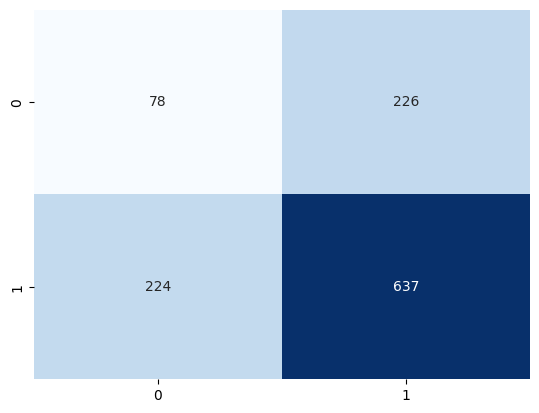

In [66]:
# Make predictions
predictions_val = model.predict(val_generator)
predicted_labels_val = np.round(predictions_val).flatten()
from sklearn.metrics import classification_report , confusion_matrix ,f1_score , accuracy_score 
import seaborn as sns
val_labels = val_generator.classes
f1_our = f1_score(val_labels, predicted_labels_val)
print(f1_our)
acc_our = accuracy_score(val_labels, predicted_labels_val)
print(acc_our)
conf_matrix_our = confusion_matrix(val_labels, predicted_labels_val)
sns.heatmap(conf_matrix_our, annot=True, fmt="d", cmap="Blues", cbar=False);

In [67]:
model.save("My_model_Task7.h5")

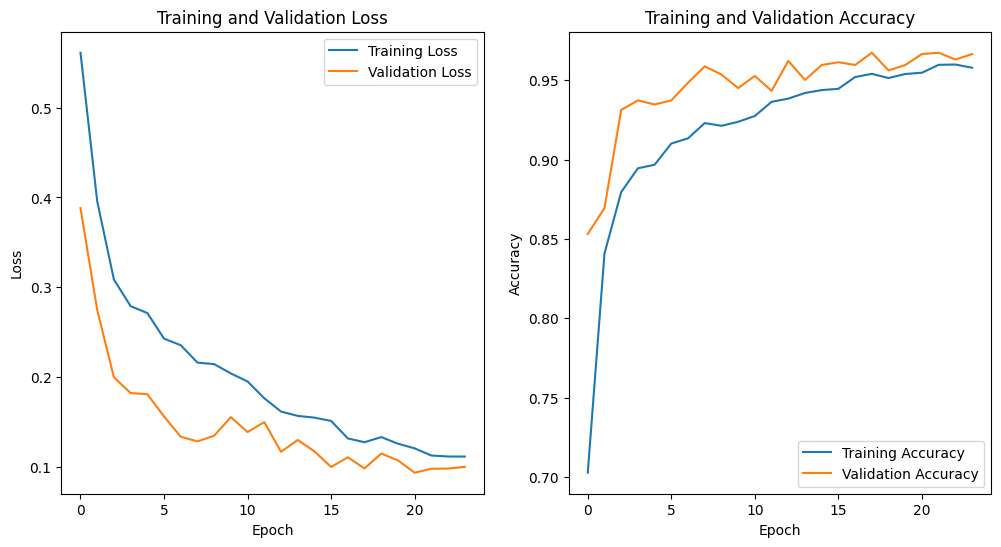

In [68]:
# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [118]:
# Make predictions
predictions = model.predict(test_generator)
predicted_labels = np.round(predictions).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


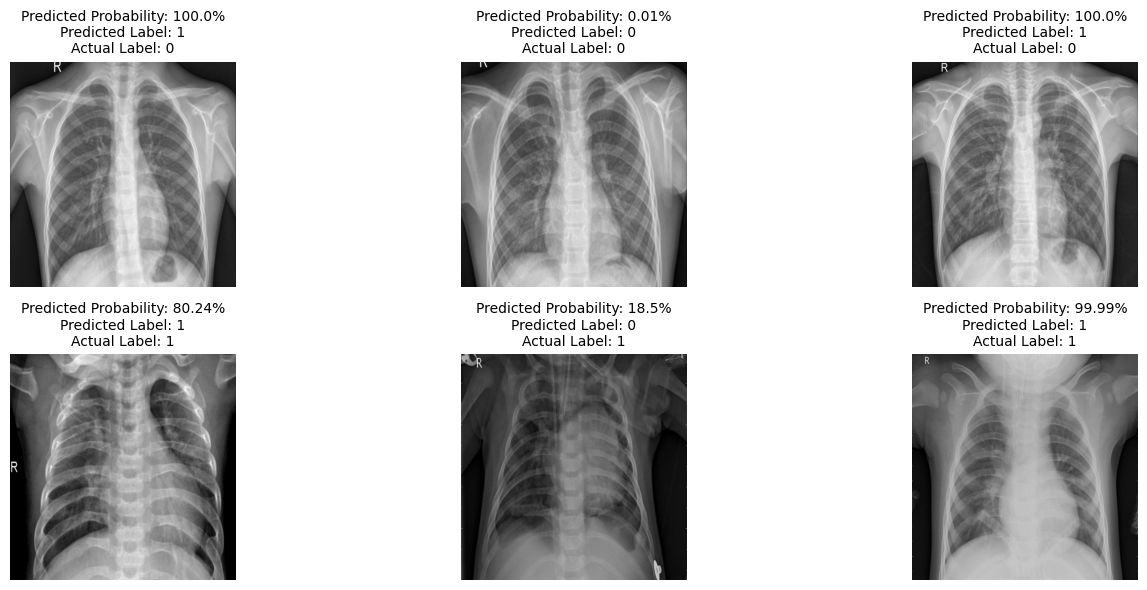

In [119]:
class_labels = ['0', '1']  # Assuming '0' represents Normal and '1' represents PUnimal
actual_labels = test_generator.labels
normal_count = 0
punimal_count = 0
selected_normal_indices = []
selected_punimal_indices = []
for i, label in enumerate(actual_labels):
    if label == 0 and normal_count < 3:  # Normal class
        selected_normal_indices.append(i)
        normal_count += 1
    elif label == 1 and punimal_count < 3:  # PUnimal class
        selected_punimal_indices.append(i)
        punimal_count += 1
selected_indices = selected_normal_indices + selected_punimal_indices
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img_index = selected_indices[i]
    img_path = test_generator.filepaths[img_index]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    pred_prob_percent = round(predictions[img_index][0] * 100, 2)
    pred_label = class_labels[int(predicted_labels[img_index])]
    actual_label = class_labels[int(actual_labels[img_index])]
    ax.set_title(f"Predicted Probability: {pred_prob_percent}%\nPredicted Label: {pred_label}\nActual Label: {actual_label}", fontsize=10)
plt.tight_layout()
plt.show()


0.7087378640776699
0.5876288659793815


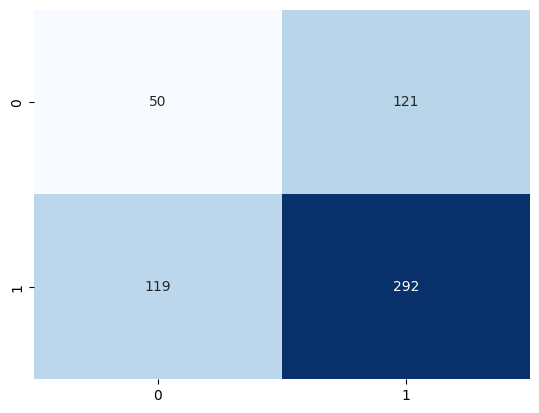

In [120]:
from sklearn.metrics import classification_report , confusion_matrix ,f1_score , accuracy_score 
import seaborn as sns
test_labels = test_generator.classes
f1_our = f1_score(test_labels, predicted_labels)
print(f1_our)
acc_our = accuracy_score(test_labels, predicted_labels)
print(acc_our)
conf_matrix_our = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(conf_matrix_our, annot=True, fmt="d", cmap="Blues", cbar=False);


In [72]:
from keras.applications import ResNet50 , VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model= VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))

In [73]:
base_model.trainable = False
model_resnet = Sequential([
            base_model,
           # Conv2D(512, (3, 3), activation='relu'), 
            #Dropout(0.2),
            Flatten(),
           # Dense(512, activation='relu'),
            #Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
])
model_resnet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [74]:
history_resnet = model_resnet.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.8171 - loss: 0.4954 - val_accuracy: 0.9348 - val_loss: 0.1742
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9148 - loss: 0.2277 - val_accuracy: 0.9245 - val_loss: 0.1950
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9253 - loss: 0.2118 - val_accuracy: 0.9382 - val_loss: 0.1610
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9212 - loss: 0.2123 - val_accuracy: 0.9536 - val_loss: 0.1276
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9255 - loss: 0.2006 - val_accuracy: 0.9605 - val_loss: 0.1187
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9195 - loss: 0.2083 - val_accuracy: 0.9468 - val_loss: 0.1497


In [75]:
val_loss_r, val_accuracy_r = model_resnet.evaluate(val_generator)

print("Validation Loss:", val_loss_r)
print("Validation Accuracy:", val_accuracy_r)

37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9361 - loss: 0.1709
Validation Loss: 0.17423084378242493
Validation Accuracy: 0.9347639679908752


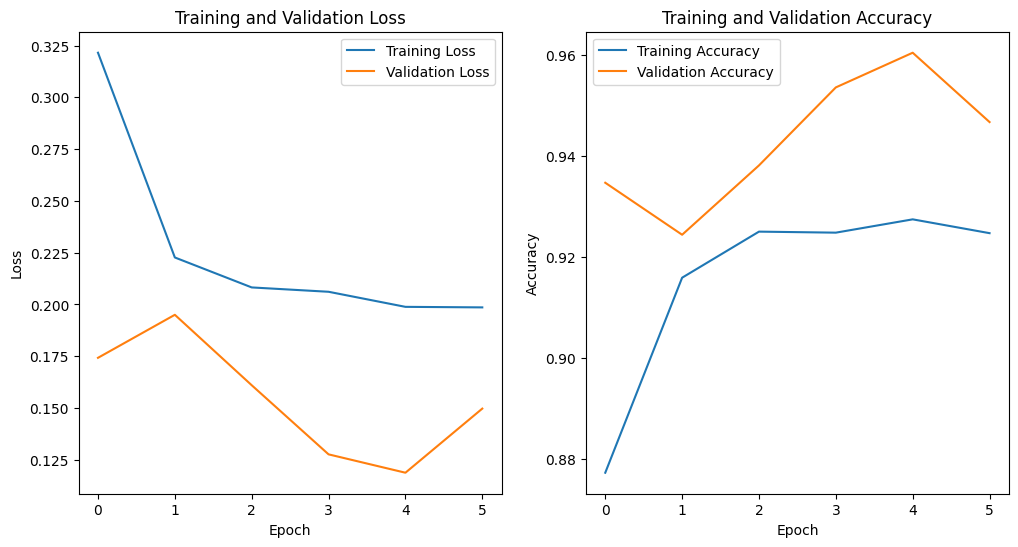

In [76]:
# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [77]:
predictions_resnet = model_resnet.predict(test_generator)
predicted_labels_r = np.round(predictions_resnet).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


0.6968553459119496
0.5859106529209622


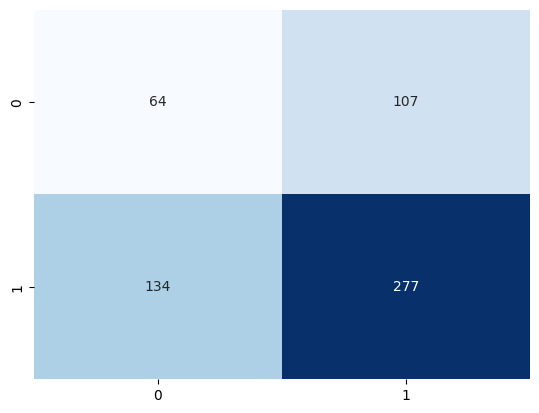

In [78]:
from sklearn.metrics import classification_report , confusion_matrix ,f1_score , accuracy_score 
import seaborn as sns
f1_vgg = f1_score(test_labels, predicted_labels_r)
print(f1_vgg)
acc_vgg = accuracy_score(test_labels, predicted_labels_r)
print(acc_vgg)
conf_matrix_vgg = confusion_matrix(test_labels, predicted_labels_r)
sns.heatmap(conf_matrix_vgg, annot=True, fmt="d", cmap="Blues", cbar=False);


## Tuner

In [79]:
import keras
from keras import layers
import keras_tuner
import numpy as np

def call_existing_code2(units, dropout, lr, num_layers):
    model_tuner = Sequential([base_model])

    model_tuner.add(Flatten())
    
    for _ in range(num_layers - 1):
        model_tuner.add(layers.Dense(units , activation= 'relu'))
        if dropout:
            model_tuner.add(layers.Dropout(0.5))


        model_tuner.add(layers.Dense(200 , activation= 'relu'))
        model_tuner.add(layers.Dense(1 , activation= 'sigmoid'))
    
    model_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model_tuner


In [80]:
def build_model2(hp):
    num_layers = hp.Int('num_layers', 1, 4)
    units = hp.Int("units", min_value=100, max_value=400, step=50)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model_tuner = call_existing_code2(
        units=units, dropout=dropout, lr=lr, num_layers=num_layers
    )
    return model_tuner



In [81]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model2,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="Models",
    project_name="Task_7",
)

In [82]:
tuner.search(train_generator, epochs=50, validation_data=(val_generator), callbacks=[early_stopping])

Trial 5 Complete [00h 40m 00s]
val_accuracy: 0.9579399228096008

Best val_accuracy So Far: 0.9613733887672424
Total elapsed time: 02h 40m 42s


In [83]:
models = tuner.get_best_models(num_models=2)
best_model = models[0] 
best_model.summary()

C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\manas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │     4,608,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 250)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,475,141 (74.29 MB)

 Trainable params: 4,760,453 (18.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [84]:
history_tuner = best_model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.9490 - loss: 0.1483 - val_accuracy: 0.9425 - val_loss: 0.1772 - learning_rate: 7.6851e-04
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9513 - loss: 0.1365 - val_accuracy: 0.9270 - val_loss: 0.2210 - learning_rate: 7.6851e-04
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.9474 - loss: 0.1407 - val_accuracy: 0.9459 - val_loss: 0.1743 - learning_rate: 7.6851e-04
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9512 - loss: 0.1317 - val_accuracy: 0.9330 - val_loss: 0.2063 - learning_rate: 7.6851e-04
Epoch 5/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9563 - loss: 0.1238 - val_accuracy: 0.9348 - val_loss: 0.2012 - learning_rate: 7.6851e-04
Epoch 6/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9551 - loss: 0.1343 - val_accuracy: 0.9622 - val_loss: 0.1014 - learning_rate: 7.6851e-04


In [85]:
val_loss_b, val_accuracy_b = best_model.evaluate(val_generator)

print("Validation Loss:", val_loss_b)
print("Validation Accuracy:", val_accuracy_b)

37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9509 - loss: 0.1588
Validation Loss: 0.17718668282032013
Validation Accuracy: 0.9424892663955688


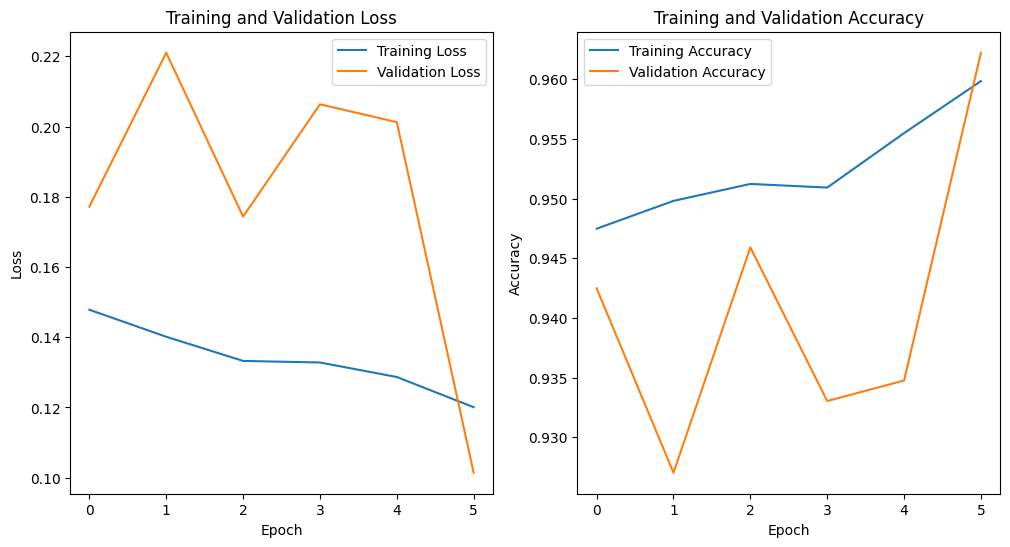

In [86]:
# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_tuner.history['loss'], label='Training Loss')
plt.plot(history_tuner.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tuner.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuner.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [87]:
predictions_tuner = best_model.predict(test_generator)
predicted_labels_b = np.round(predictions_tuner).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


0.6842767295597484
0.5687285223367697


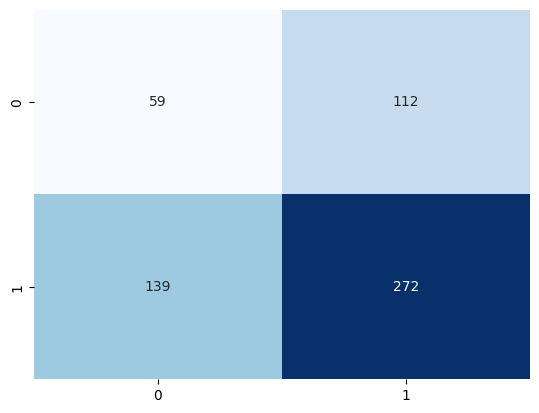

In [88]:
from sklearn.metrics import classification_report , confusion_matrix ,f1_score , accuracy_score 
import seaborn as sns
f1_t = f1_score(test_labels, predicted_labels_b)
print(f1_t)
acc_t = accuracy_score(test_labels, predicted_labels_b)
print(acc_t)
conf_matrix_t = confusion_matrix(test_labels, predicted_labels_b)
sns.heatmap(conf_matrix_t, annot=True, fmt="d", cmap="Blues", cbar=False);


## Comparison

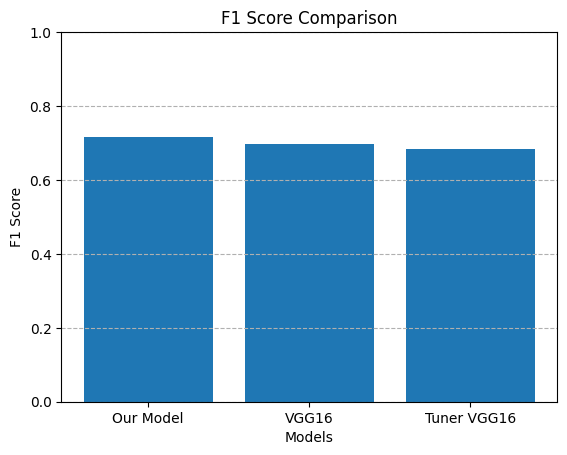

In [112]:
import matplotlib.pyplot as plt

# F1 scores for each model/method
f1_scores = [f1_our, f1_vgg, f1_t]

# Model/method names for plotting
models = ['Our Model', 'VGG16', 'Tuner VGG16']

# Create bar plot
plt.bar(models, f1_scores)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=1)
plt.show()
